In [924]:
import sys
print(sys.version)

3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 23:03:10) [MSC v.1916 64 bit (AMD64)]


In [925]:
import pandas as pd
df_train = pd.read_csv('dataset_train_NASDAQ100.csv')
df_test = pd.read_csv('dataset_test_sp500.csv')
df_train

,Symbol,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio,target
0,ATVI,90.07,50.51,92.99,4409111.0,6510317.0,7.056200e+10,32.05,2.85,Overvalued
1,ADBE,480.00,255.13,536.88,2266132.0,2510958.0,2.327120e+11,44.79,10.83,Overvalued
2,AMD,95.98,36.75,97.98,39520899.0,45555233.0,1.138810e+11,128.16,0.74,Overvalued
3,ALXN,156.79,72.67,160.03,2861609.0,2414704.0,3.441600e+10,36.52,4.31,Undervalued
4,ALGN,561.63,127.88,579.04,464242.0,683792.0,4.498700e+10,25.96,21.98,Near Fair Value
...,...,...,...,...,...,...,...,...,...,...
97,WBA,45.05,33.36,54.88,9895372.0,8215398.0,3.905700e+10,NaN,-0.80,Overvalued
98,WDAY,226.00,107.75,259.01,1666914.0,2081525.0,5.463600e+10,NaN,-1.45,Overvalued
99,XEL,65.06,46.58,76.44,2221705.0,2487246.0,3.533300e+10,23.41,2.81,Overvalued
100,XLNX,150.45,67.68,154.12,2856568.0,3928238.0,3.627600e+10,60.45,2.45,Overvalued


In [926]:
# perform preprocessing data before they can be used

# drop near fair value
df_train_drop_fair_value = df_train[df_train['target'] != 'Near Fair Value']
df_test_drop_fair_value = df_test[df_test['target'] != 'Near Fair Value']
# print(df_test_drop_na['target'])

# removing N/A
df_train_drop_na = df_train_drop_fair_value.dropna()
df_test_drop_na = df_test_drop_fair_value.dropna()

# remove intersection between two dataframes in test set
df_test_drop_na = pd.merge(df_test_drop_na, df_train_drop_na, how='outer', indicator=True).query('_merge=="left_only"').drop(['_merge'], axis=1)

# drop Symbol col
p_df_train = df_train_drop_na.drop(['Symbol', 'target'], axis=1)
p_df_test = df_test_drop_na.drop(['Symbol', 'target'], axis=1)

# p_df_train
p_df_test

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,174.12,114.04,182.55,1779190.0,2324304.0,1.008230e+11,20.50,8.53
1,108.17,61.61,115.14,2779390.0,4760728.0,1.940560e+11,57.90,1.89
2,105.26,62.55,109.15,5690813.0,8076007.0,1.891700e+11,23.44,4.57
3,257.60,137.15,271.18,1261375.0,1853069.0,1.730680e+11,32.15,8.12
4,91.74,50.51,92.99,4311046.0,6489270.0,7.176000e+10,32.59,2.85
...,...,...,...,...,...,...,...,...
305,142.10,67.68,154.12,1236254.0,3841690.0,3.475100e+10,57.91,2.45
306,108.74,54.95,110.66,1330971.0,1573888.0,3.274900e+10,31.52,3.44
307,383.72,150.06,388.92,169632.0,358241.0,2.049100e+10,43.87,8.76
308,43.20,23.58,51.68,706674.0,2054834.0,7.125000e+09,18.37,2.37


In [927]:
# standardize features
sdd_df_train = ((p_df_train) - p_df_train.mean()) / p_df_train.std()
sdd_df_test = ((p_df_test) - p_df_test.mean()) / p_df_test.std()
sdd_df_train


,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,-0.513703,-0.429883,-0.546750,-0.202300,-0.064175,-0.303052,-0.274114,-0.368666
1,0.706793,0.749206,0.774809,-0.333282,-0.314383,0.115559,-0.215362,0.480508
2,-0.495205,-0.509172,-0.531894,1.943781,2.378554,-0.191219,0.169107,-0.593198
3,-0.304867,-0.302189,-0.347157,-0.296885,-0.320405,-0.396368,-0.253500,-0.213304
5,4.766954,5.092508,4.665888,-0.363348,-0.367512,2.664371,-0.261708,4.834921
...,...,...,...,...,...,...,...,...
95,-0.165706,-0.048992,-0.196420,-0.436769,-0.432720,-0.400891,-0.191981,-0.243099
96,-0.063635,0.416950,0.087666,-0.396539,-0.335709,-0.326114,-0.314788,0.413468
99,-0.591986,-0.452529,-0.596023,-0.335997,-0.315866,-0.394001,-0.313958,-0.372923
100,-0.324712,-0.330943,-0.364752,-0.297193,-0.225715,-0.391566,-0.143144,-0.411232


In [928]:
print('df_train_drop_na: ', len(df_train_drop_na['target']))
print('df_test_drop_na: ', len(df_test_drop_na['target']))

df_train_drop_na:  69
df_test_drop_na:  310


In [929]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# find score for Gaussian Naive Bayes classifer
gnb = GaussianNB()
gnb.fit(sdd_df_train, df_train_drop_na['target'])
gnb_score = gnb.score(sdd_df_test, df_test_drop_na['target'])
print("GNB classifer score (accuracy) = ", gnb_score)

# find score for KNN classifer
knn = KNeighborsClassifier()
knn.fit(sdd_df_train, df_train_drop_na['target'])
knn_score = knn.score(sdd_df_test, df_test_drop_na['target'])
print("KNN classifer score (accuracy) = ", knn_score)

# find score for SVM classifier
svm = SVC()
svm.fit(sdd_df_train, df_train_drop_na['target'])
svm_score = svm.score(sdd_df_test, df_test_drop_na['target'])
print("SVM classifer score (accuracy) = ", svm_score)

GNB classifer score (accuracy) =  0.8258064516129032
KNN classifer score (accuracy) =  0.832258064516129
SVM classifer score (accuracy) =  0.8290322580645161


In [930]:
print('df_train_drop_na', df_train_drop_na['target'].shape)
print('p_df_train', sdd_df_train.shape)
print('df_test_drop_na', df_test_drop_na['target'].shape)
print('p_df_test', sdd_df_test.shape)

df_train_drop_na (69,)
p_df_train (69, 8)
df_test_drop_na (310,)
p_df_test (310, 8)


In [931]:
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(sdd_df_test, df_test_drop_na['target'],test_size=0.1, random_state=42, shuffle=True)

print('X_train.shape:', X_train.shape)
print('X_test.shape', X_test.shape)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = np.asarray(y_train).astype('float32')
y_test = label_encoder.fit_transform(y_test)
y_test = np.asarray(y_test).astype('float32')

# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_train = to_categorical(np.asarray(y_train).astype('float32'))

# y_test = label_encoder.fit_transform(y_test)
# y_test = to_categorical(np.asarray(y_test).astype('float32'))

model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(8,)))
model.add(Dense(200, activation='relu', input_dim=8))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Flatten())
model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
# opt = SGD(lr=0.01, momentum=0.9)
opt = 'rmsprop'
# opt = Adam(lr=0.001)
# opt = 'adadelta'
# opt = 'adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=60, epochs=10, verbose=1, validation_split=0.25)
history = model.fit(X_train, y_train, batch_size=8, epochs=4, verbose=1, validation_data=(X_test, y_test))
model.summary()


results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)

print('\n')
print('results_train: ', results_train)
print('results_test:', results_test)


# X_train

X_train.shape: (279, 8)
X_test.shape (31, 8)
Epoch 1/4
35/35 [==============================] - 1s 6ms/step - loss: 0.5847 - accuracy: 0.7305 - val_loss: 0.4968 - val_accuracy: 0.7742
Epoch 2/4
35/35 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8712 - val_loss: 0.4190 - val_accuracy: 0.8387
Epoch 3/4
35/35 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8249 - val_loss: 0.4140 - val_accuracy: 0.7742
Epoch 4/4
35/35 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8574 - val_loss: 0.3673 - val_accuracy: 0.8710
Model: "sequential_642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1987 (Dense)           (None, 200)               1800      
_________________________________________________________________
dense_1988 (Dense)           (None, 200)               40200     
_____________________________________________

In [932]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

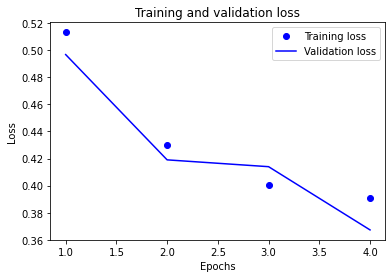

In [933]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

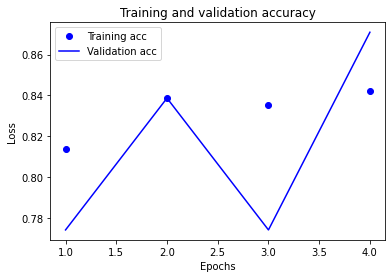

In [934]:
plt.clf()
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [935]:
# define neural network model
def baseline_model():
    model = Sequential()
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=8))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = 'rmsprop'
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [936]:
# evaluate model with k-fold cross validation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_test_drop_na['target'])
# y_train = to_categorical(df_test_drop_na['target'])
# print(y_train)
r = cross_val_score(estimator, sdd_df_test, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (r.mean()*100, r.std()*100))

Baseline: 83.23% (6.42%)


In [937]:
# make prediction using model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

NameError: name 'y_' is not defined

In [895]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
con_mat = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(con_mat, annot=True, ax=ax)

ValueError: Classification metrics can't handle a mix of binary and continuous targets